## I.- Preparing

### Libraries

In [110]:
import cv2
import imageio 
import matplotlib.pyplot as plt 
from IPython.display import HTML, display
import numpy as np 
import tensorflow as tf 
import tensorflow_hub as hub

### Setup

In [111]:
blue = (26, 128, 187)
orange = (234, 128, 28)

EDGE_COLORS = {
    (0, 1): blue,
    (0, 2): orange,
    (1, 3): blue,
    (2, 4): orange,
    (0, 5): blue,
    (0, 6): orange,
    (5, 7): blue,
    (7, 9): blue,
    (6, 8): orange,
    (8, 10): orange,
    (5, 6): blue,
    (5, 11): blue,
    (6, 12): orange,
    (11, 12): orange,
    (11, 13): blue,
    (13, 15): blue,
    (12, 14): orange,
    (14, 16): orange
}

### Load Model from Tensor Flow Hub

Lightning : intended for latency-critical applications
\
Thunder : for applications that require high accuracy

In [112]:
interpreter = tf.lite.Interpreter(model_path='./Models/movenet_thunder_f16.tflite')
interpreter.allocate_tensors()

def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores



In [ ]:
module = tf.saved_model.load('./Models/Saved')
movenet = module.signatures['serving_default']


def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores


### Adjust input size

In [123]:
#initial_width, initial_height = (461,250)
WIDTH = HEIGHT = 256

## II.- Inference


### Define loop

In [124]:
def loop(frame, keypoints, threshold=0.11):
    """
    Main loop : Draws the keypoints and edges for each instance
    """
    
    # Loop through the results
    for instance in keypoints: 
        # Draw the keypoints
        denormalized_coordinates = draw_keypoints(frame, instance, threshold)
        # Draw the edges
        draw_edges(denormalized_coordinates, frame, EDGE_COLORS, threshold)

### Keypoints

In [125]:
def draw_keypoints(frame, keypoints, threshold=0.11):
    """Draws the keypoints on a image frame"""
    
    # Denormalize the coordinates of the keypoints 
    denormalized_coordinates = np.squeeze(np.multiply(keypoints, [WIDTH,HEIGHT,1]))
    for keypoint in denormalized_coordinates:
        # Unpack the keypoint values
        keypoint_y, keypoint_x, keypoint_confidence = keypoint
        if keypoint_confidence > threshold:
            # Draw the keypoints
            cv2.circle(
                img=frame, 
                center=(int(keypoint_x), int(keypoint_y)), 
                radius=4, 
                color=(255,0,0),
                thickness=-1
            )
    return denormalized_coordinates

### Edges

In [126]:
def draw_edges(denormalized_coordinates, frame, edges_colors, threshold=0.11):
    for edge, color in edges_colors.items():
        # Get the dict value associated to the actual edge
        p1, p2 = edge
        # Get the points
        y1, x1, confidence_1 = denormalized_coordinates[p1]
        y2, x2, confidence_2 = denormalized_coordinates[p2]
        # Draw the line from point 1 to point 2, the confidence > threshold
        if (confidence_1 > threshold) & (confidence_2 > threshold):      
            cv2.line(
                img=frame, 
                pt1=(int(x1), int(y1)),
                pt2=(int(x2), int(y2)), 
                color=color, 
                thickness=2, 
                lineType=cv2.LINE_AA
            )

## Progress bar

In [127]:

def progress(value, max=100):
    return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value,
                max=max))

## Process each frame

### Load media

In [128]:
def load_gif():    
    # Load the gif
    gif = cv2.VideoCapture("../Sample_gifs/Spiderman3.gif")
    # Get the frame count
    frame_count = int(gif.get(cv2.CAP_PROP_FRAME_COUNT))
    # Display parameter
    print(f"Frame count: {frame_count}")
    
    """""
    Initialize the video writer 
    We'll append each frame and its drawing to a vector, then stack all the frames to obtain a sequence (video). 
    """
    output_frames = []
    
    # Get the initial shape (width, height)
    initial_shape = []
    initial_shape.append(int(gif.get(cv2.CAP_PROP_FRAME_WIDTH)))
    initial_shape.append(int(gif.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    
    return gif, frame_count, output_frames, initial_shape

### Run inference

In [129]:
def run_inference():
    """
    Runs inferences then starts the main loop for each frame
    """
    
    # Load the gif
    gif, frame_count, output_frames, initial_shape = load_gif()
    # Set the progress bar to 0. It ranges from the first to the last frame
    bar = display(progress(0, frame_count-1), display_id=True)
    
    # Loop while the gif is opened
    while gif.isOpened():
        
        # Capture the frame
        ret, frame = gif.read()
        
        # Exit if the frame is empty
        if frame is None: 
            break
        
        # Retrieve the frame index
        current_index = gif.get(cv2.CAP_PROP_POS_FRAMES)
        
        # Copy the frame
        image = frame.copy()
        image = cv2.resize(image, (WIDTH,HEIGHT))
        # Resize to the target shape and cast to an int32 vector
        input_image = tf.cast(tf.image.resize_with_pad(image, WIDTH, HEIGHT), dtype=tf.int32)
        # Create a batch (input tensor)
        input_image = tf.expand_dims(input_image, axis=0)

        # Perform inference
        results = movenet(input_image)
        """
        Output shape :  [1, 6, 56] ---> (batch size), (instances), (xy keypoints coordinates and score from [0:50] 
        and [ymin, xmin, ymax, xmax, score] for the remaining elements)
        First, let's resize it to a more convenient shape, following this logic : 
        - First channel ---> each instance
        - Second channel ---> 17 keypoints for each instance
        - The 51st values of the last channel ----> the confidence score.
        Thus, the Tensor is reshaped without losing important information. 
        """

        # Loop through the results
        loop(image, results, threshold=0.11)
        
        # Get the output frame : reshape to the original size
        frame_rgb = cv2.cvtColor(
            cv2.resize(
                image,(initial_shape[0], initial_shape[1]), 
                interpolation=cv2.INTER_LANCZOS4
            ), 
            cv2.COLOR_BGR2RGB # OpenCV processes BGR images instead of RGB
        ) 
        
        # Add the drawings to the output frames
        output_frames.append(frame_rgb)
        
        # Update the progress bar
        bar.update(progress(current_index, frame_count-1))
    
    # Release the object
    gif.release()
    
    print("Complete")
    
    return output_frames

In [130]:
output_frames = run_inference()

Frame count: 58


Complete


## Display Results

In [131]:
from tensorflow_docs.vis import embed


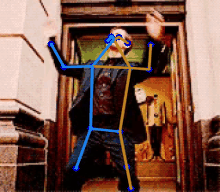

In [134]:
# Stack the output frames horizontally to compose a sequence
output = np.stack(output_frames, axis=0) 
# Write the sequence to a gif
imageio.mimsave("./test.gif", output, fps=10) 
# Embed the output to the notebook
embed.embed_file("./test.gif") 
